<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/Distilbert_multi_doppio_val_F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00


In [42]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


# Data loading

In [15]:
df_dev = load_dataset("csv", data_files="dataset/subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

# Data partioning

In [18]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=0)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [19]:
df_train = train_val["train"]
df_val_ = train_val["test"]

In [20]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val_ = df_val_.rename_column("comment_text", "text")
df_val_ = df_val_.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

In [21]:
df_val_

Dataset({
    features: ['text', 'labels'],
    num_rows: 552
})

In [22]:
df_val_ = df_val_.train_test_split(test_size=0.3, seed=0)

In [23]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 386
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 166
    })
})

In [24]:
df_val = df_val_["train"]
df_val2 = df_val_["test"]

In [27]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1288
})

In [25]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 386
})

In [26]:
df_val2

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

# Model loading

In [28]:
nome = 'distilbert_multi_default' # modificare

In [29]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Data preprocessing

In [30]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [31]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Training

In [32]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=0
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [33]:
config = AutoConfig.from_pretrained("distilbert-base-multilingual-cased")

In [ ]:
# config.dropout = 0.001

In [ ]:
print(config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 119547
}



In [34]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", config=config)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [35]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [37]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.604700,0.556554,0.725858
2,0.446200,0.551162,0.756451
3,0.288900,0.854731,0.774355
4,0.145900,1.267147,0.766614
5,0.063200,1.427157,0.769243
6,0.033500,1.503926,0.776819
7,0.007300,1.724697,0.757503
8,0.010800,1.815627,0.774428
9,0.002800,1.866956,0.760572
10,0.001800,1.904178,0.763256


CPU times: user 16min 42s, sys: 34.7 s, total: 17min 17s
Wall time: 29min 47s


TrainOutput(global_step=2415, training_loss=0.10757340347051127, metrics={'train_runtime': 1786.9474, 'train_samples_per_second': 10.812, 'train_steps_per_second': 1.351, 'total_flos': 2559270142033920.0, 'train_loss': 0.10757340347051127, 'epoch': 15.0})

# Evaluation

In [38]:
log_history = trainer.state.log_history

In [39]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

<ipython-input-39-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-39-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-39-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-39-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

,Epoch,Loss,Dataset
0,1,0.604700,Training
1,1,0.556554,Validation
2,2,0.446200,Training
3,2,0.551162,Validation
4,3,0.288900,Training
5,3,0.854731,Validation
6,4,0.145900,Training
7,4,1.267147,Validation
8,5,0.063200,Training
9,5,1.427157,Validation


In [ ]:
#df.to_html(f'loss_{nome}.html')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Epoch</th>
      <th>Loss</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>0.697200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0.669174</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0.635500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>0.670862</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>0.587900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>0.672889</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>0.539400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>0.677192</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>8</th>
      <td>5</td>
      <td>0.466300</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>9</th>
      <td>5</td>
      <td>0.680526</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>10</th>
      <td>6</td>
      <td>0.411400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>11</th>
      <td>6</td>
      <td>0.690356</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>12</th>
      <td>7</td>
      <td>0.356700</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>13</th>
      <td>7</td>
      <td>0.708966</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>14</th>
      <td>8</td>
      <td>0.321200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>15</th>
      <td>8</td>
      <td>0.732528</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>16</th>
      <td>9</td>
      <td>0.293900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>17</th>
      <td>9</td>
      <td>0.758814</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>18</th>
      <td>10</td>
      <td>0.272400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>19</th>
      <td>10</td>
      <td>0.784720</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>20</th>
      <td>11</td>
      <td>0.249000</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>21</th>
      <td>11</td>
      <td>0.810367</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>22</th>
      <td>12</td>
      <td>0.233400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>23</th>
      <td>12</td>
      <td>0.833654</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>24</th>
      <td>13</td>
      <td>0.192100</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>25</th>
      <td>13</td>
      <td>0.852435</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>26</th>
      <td>14</td>
      <td>0.191500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>27</th>
      <td>14</td>
      <td>0.865037</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>28</th>
      <td>15</td>
      <td>0.180900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>29</th>
      <td>15</td>
      <td>0.871067</td>
      <td>Validation</td>
    </tr>
  </tbody>
</table>

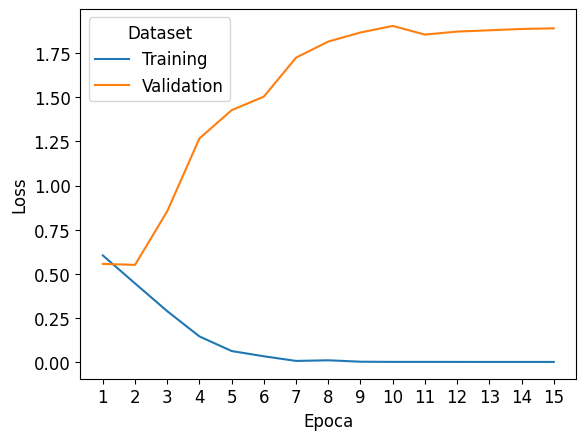

In [50]:
# loss lineplot
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_doppioval_f1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
output_predictions = trainer.predict(tokenized_val2)

In [47]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.69      0.70        81
           1       0.71      0.72      0.71        85

    accuracy                           0.70       166
   macro avg       0.70      0.70      0.70       166
weighted avg       0.70      0.70      0.70       166



In [48]:
with open(f"class_report_{nome}_doppioval_f1.html", "w") as file:
    file.write(report)

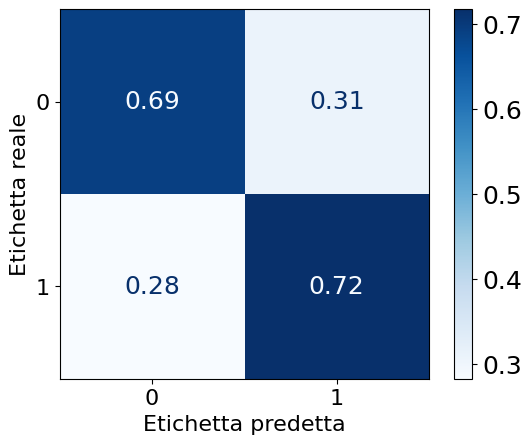

In [49]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_doppioval_f1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
model_directory = 'distilbert_multi_default-finetuned/checkpoint-805'

In [53]:
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

In [54]:
trainer = Trainer(model=model)

In [55]:
output_prediction_loss = trainer.predict(tokenized_val2)

In [57]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction_loss.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        81
           1       0.73      0.68      0.71        85

    accuracy                           0.71       166
   macro avg       0.71      0.71      0.71       166
weighted avg       0.71      0.71      0.71       166

